#**Brain Tumor Detection Using Computer vision**

# 1. Importing the libraries

In [2]:
import os
import numpy as np
import pandas as pd

#Deep learning utilities
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import VGG16
from sklearn.utils import shuffle

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
from tensorflow import test
# Directories for the training and testing data
train_dir = '/content/drive/MyDrive/Deep learning DataSets/Brain Tumor/Training'
test_dir = '/content/drive/MyDrive/Deep learning DataSets/Brain Tumor/Testing'

#loading and shuffling the training data
train_paths = []
train_labels = [] # Corrected to train_labels

for label in os.listdir(train_dir):
  for image in os.listdir(os.path.join(train_dir, label)):
    train_paths.append(os.path.join(train_dir, label, image))
    train_labels.append(label) # Corrected to train_labels

train_paths, train_labels = shuffle(train_paths, train_labels) # Corrected to train_labels

# loading and shuffling the testing data
test_paths = []
test_labels = [] # Corrected to test_labels

for label in os.listdir(test_dir): # Changed to test_dir
  for image in os.listdir(os.path.join(test_dir, label)): # Changed to test_dir
    test_paths.append(os.path.join(test_dir, label, image))
    test_labels.append(label) # Corrected to test_labels

test_paths, test_labels = shuffle(test_paths, test_labels) # Corrected to test_labels

# Data Visualization

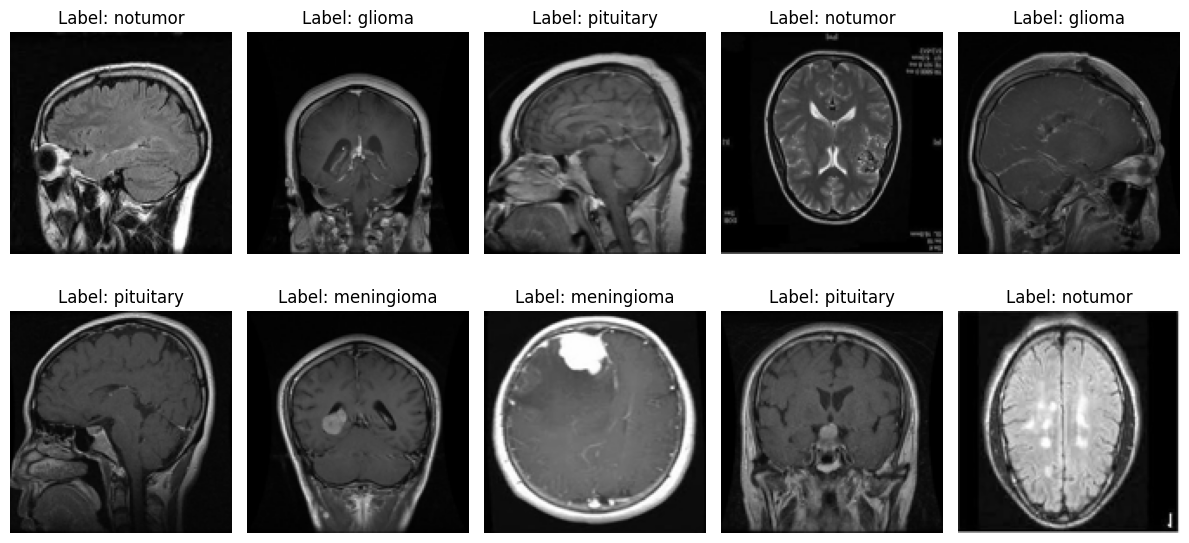

In [5]:
import random
import matplotlib.pyplot as plt

# SElelct random indices for 10 images
random_indices = random.sample(range(len(train_paths)), 10)

# Creating afigure to display the images in 2 rows
fig, axes = plt.subplots(2, 5, figsize=(12, 6))

axes = axes.ravel()

#loop through the rnadom indices and display images
for i, idex in enumerate(random_indices):
  img_paths = train_paths[idex]
  img = load_img(img_paths)
  img = img.resize((128, 128))

  # Display Images
  axes[i].imshow(img)
  axes[i].set_title(f'Label: {train_labels[idex]}') # Changed from test_labels to train_labels
  axes[i].axis('off')

plt.tight_layout()
plt.show()

# Image Preprocessing

In [9]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from sklearn.utils import shuffle

# Get unique labels and create mapping for encoding
# Assumes train_dir is defined and contains subdirectories as labels
unique_labels = sorted([d for d in os.listdir(train_dir) if os.path.isdir(os.path.join(train_dir, d))])
label_to_int = {label: i for i, label in enumerate(unique_labels)}

# Image Augmentation Function (basic placeholder)
def augment_image(image):
  # Add more sophisticated image augmentation techniques here if desired
  return image

# Load images and preprocess
def open_images(image_path, target_size=(IMAGE_SIZE, IMAGE_SIZE)):
  img = load_img(image_path, target_size=target_size)
  img = img_to_array(img)
  img = img / 255.0  # Normalize pixel values to [0, 1]
  return img

# Label Encoder
def encode_label(label_name):
  return label_to_int.get(label_name) # Returns None if label_name is not found

# Data generation for the batch size
def data_generation(image_paths, batch_size=12, epochs=1):
  num_images = len(image_paths)
  for epoch_idx in range(epochs):
    shuffled_paths = shuffle(image_paths)
    images_batch = []
    labels_batch = []

    for i in range(num_images):
      img_path = shuffled_paths[i]
      # Extract label from path (e.g., '/content/drive/MyDrive/Brain Tumor/Training/glioma/Tr-gl_001.jpg' -> 'glioma')
      label_name = os.path.basename(os.path.dirname(img_path))

      img = open_images(img_path)
      img = augment_image(img) # Apply augmentation

      label_encoded = encode_label(label_name)

      if label_encoded is not None: # Only add if label is known
        images_batch.append(img)
        labels_batch.append(label_encoded)

      if len(images_batch) == batch_size:
        yield np.array(images_batch, dtype=np.float32), np.array(labels_batch, dtype=np.int32)
        images_batch = []
        labels_batch = []

    # Yield any remaining images if the last batch is smaller than batch_size
    if len(images_batch) > 0:
        yield np.array(images_batch, dtype=np.float32), np.array(labels_batch, dtype=np.int32)

# Task
Refine the existing VGG16 model by unfreezing all convolutional layers within `block4` and `block5` for more extensive fine-tuning. Subsequently, retrain the model with this updated architecture, and then re-evaluate its performance using a classification report, confusion matrix, and ROC curve to assess improvements in classification metrics, particularly 'glioma' precision and 'meningioma' recall.

## Refine Model Architecture (Fine-tune VGG16)

### Subtask:
Modify the existing VGG16 base model to unfreeze additional convolutional layers, specifically those within `block4` and `block5`, allowing for more extensive fine-tuning of the pre-trained weights to better suit the brain tumor classification task.


**Reasoning**:
To refine the model architecture as instructed, I need to modify the code cell responsible for initializing and freezing the VGG16 base model layers. The modification involves iterating through the base model layers and selectively unfreezing those whose names contain 'block4' or 'block5', while keeping others frozen.



In [10]:
IMAGE_SIZE = 128
base_model = VGG16(input_shape=(IMAGE_SIZE, IMAGE_SIZE, 3), include_top=False, weights='imagenet')

# Unfreeze layers in 'block4' and 'block5', and freeze others
for layer in base_model.layers:
    if 'block4' in layer.name or 'block5' in layer.name:
        layer.trainable = True
    else:
        layer.trainable = False

# Now building the layers

model = Sequential()
model.add(base_model) # VGG16 MODEL
model.add(Flatten()) # Flatten layer
model.add(Dropout(0.3)) # Dropout for the overfitting

model.add(Dense(128, activation = "relu")) # Dense layer
model.add(Dropout(0.2))

model.add(Dense(len(os.listdir(train_dir)), activation = "softmax")) # Output layer

# Compiling the model
model.compile(optimizer = Adam(learning_rate = 0.0001), loss = "sparse_categorical_crossentropy", metrics = ["sparse_categorical_accuracy"])

# Giving the parameters
batch_size = 20
steps = int(len(train_paths) / batch_size)
epochs = 5

# Training the  model
history = model.fit(
    data_generation(train_paths, batch_size = batch_size, epochs = epochs),
    steps_per_epoch = steps,
    epochs = epochs,
    verbose = 1
)

Epoch 1/5
285/285 ━━━━━━━━━━━━━━━━━━━━ 1256s 4s/step - loss: 0.6831 - sparse_categorical_accuracy: 0.7189
Epoch 2/5
285/285 ━━━━━━━━━━━━━━━━━━━━ 38s 95ms/step - loss: 0.2164 - sparse_categorical_accuracy: 0.9197
Epoch 3/5
285/285 ━━━━━━━━━━━━━━━━━━━━ 27s 94ms/step - loss: 0.1259 - sparse_categorical_accuracy: 0.9549
Epoch 4/5
285/285 ━━━━━━━━━━━━━━━━━━━━ 27s 95ms/step - loss: 0.1156 - sparse_categorical_accuracy: 0.9603
Epoch 5/5
285/285 ━━━━━━━━━━━━━━━━━━━━ 27s 95ms/step - loss: 0.0530 - sparse_categorical_accuracy: 0.9814


# Save The Model

In [11]:
model.save("Brain_Tumor_Detection.keras")

In [13]:
model.save("Brain_Tumor_Detection_1.h5")


# Ploting the Training vs validation

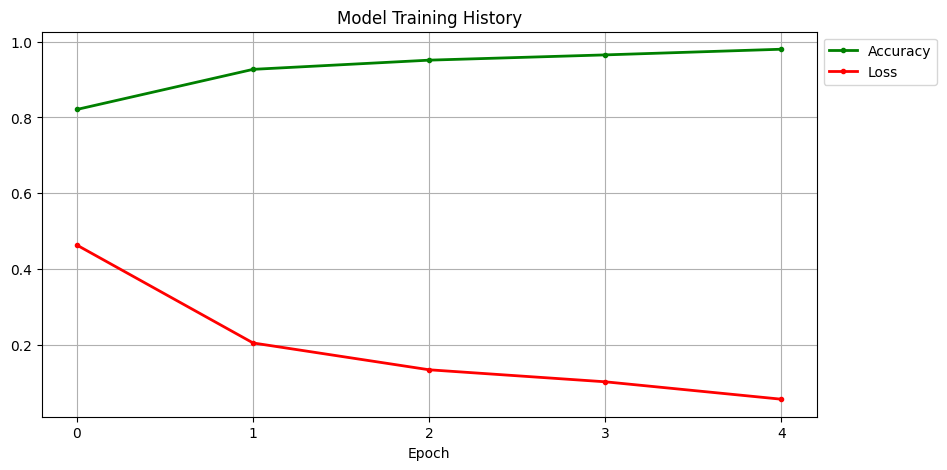

In [14]:
plt.figure(figsize=(10,5))
plt.grid(True)
plt.plot(history.history['sparse_categorical_accuracy'], '.g-', linewidth=2)
plt.plot(history.history['loss'], '.r-', linewidth=2)
plt.title('Model Training History')
plt.xlabel('Epoch')
plt.xticks([x for x in range(epochs)])
plt.legend(['Accuracy', 'Loss'], loc='upper left', bbox_to_anchor=(1, 1))
plt.show()

In [15]:
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
import seaborn as sns
from sklearn.preprocessing import label_binarize
from tensorflow.keras.models import load_model
import numpy as np

# 1. Prediction on test data

# Load and preprocess all test images
processed_test_images = []
for path in test_paths:
  processed_test_images.append(open_images(path))
test_images_array = np.array(processed_test_images) # Convert list of images to a numpy array

# Encode the test labels
test_labels_encoded = []
for label_name in test_labels:
  test_labels_encoded.append(encode_label(label_name))
test_labels_encoded = np.array(test_labels_encoded) # Convert list of encoded labels to a numpy array

# Predict using the trained model
test_predictions = model.predict(test_images_array)

# 2. Classification Report
print("Classification Report:")
print(classification_report(test_labels_encoded, np.argmax(test_predictions, axis=1)))

43/43 ━━━━━━━━━━━━━━━━━━━━ 13s 180ms/step
Classification Report:
              precision    recall  f1-score   support

           0       0.92      0.98      0.95       317
           1       0.97      0.89      0.93       311
           2       0.98      1.00      0.99       443
           3       0.99      0.98      0.98       300

    accuracy                           0.96      1371
   macro avg       0.96      0.96      0.96      1371
weighted avg       0.97      0.96      0.96      1371



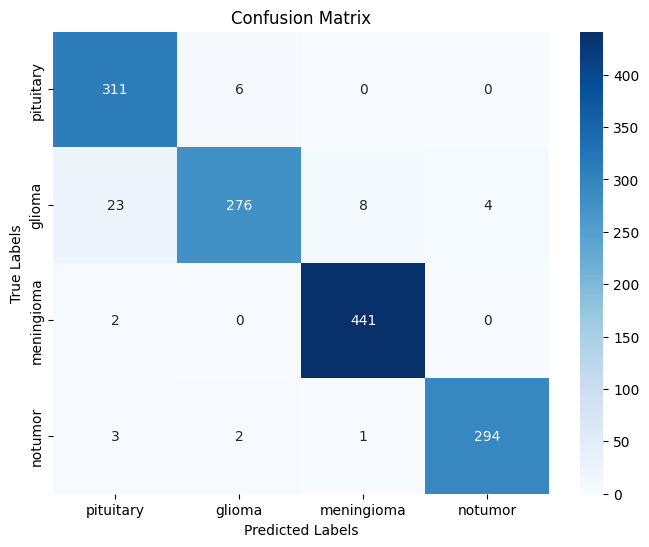

In [16]:
# 3. Confusion Matrix
conf_matrix = confusion_matrix(test_labels_encoded, np.argmax(test_predictions, axis=1))
#print("Confusion Matrix:")
#print(conf_matrix)

# Plot the Confusion Matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=os.listdir(train_dir), yticklabels=os.listdir(train_dir))
plt.title("Confusion Matrix")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()

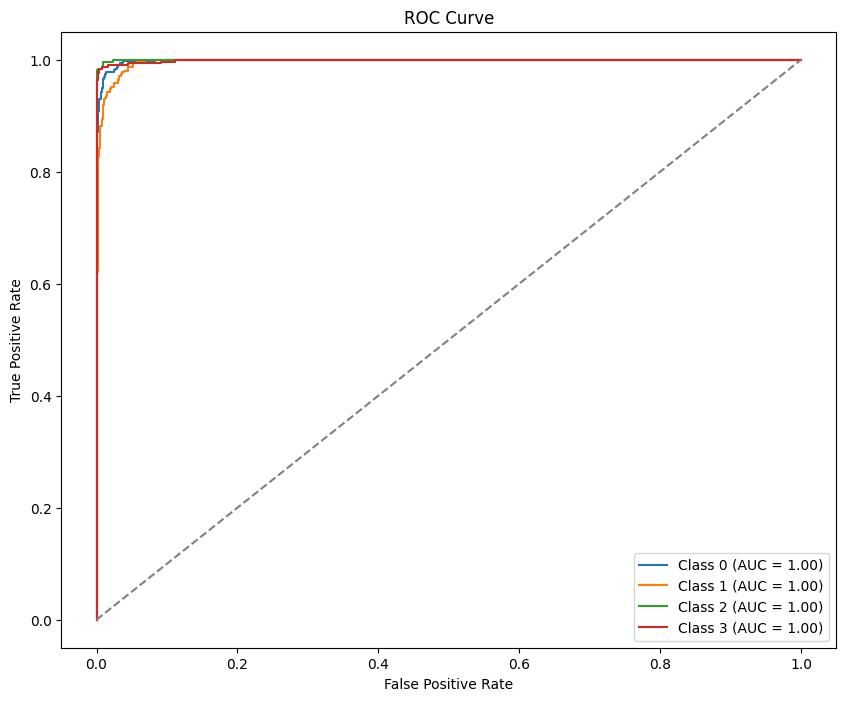

In [17]:
# 4. ROC Curve and AUC
# Binarize the test labels and predictions for multi-class ROC
test_labels_bin = label_binarize(test_labels_encoded, classes=np.arange(len(os.listdir(train_dir))))
test_predictions_bin = test_predictions  # The predicted probabilities for each class

# Compute ROC curve and ROC AUC for each class
fpr, tpr, roc_auc = {}, {}, {}
for i in range(len(os.listdir(train_dir))):
    fpr[i], tpr[i], _ = roc_curve(test_labels_bin[:, i], test_predictions_bin[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot ROC curve
plt.figure(figsize=(10, 8))
for i in range(len(os.listdir(train_dir))):
    plt.plot(fpr[i], tpr[i], label=f'Class {i} (AUC = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], linestyle='--', color='gray')  # Diagonal line
plt.title("ROC Curve")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(loc="lower right")
plt.show()